# HW 9: Bayesian inference

# Part (a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
%matplotlib inline

# Read in data
fname = './location_data_hw9_2018.csv'
df = pd.read_csv(fname)

df.head()

/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y
0,1.718397,1.330174,0.993564,1.081700,-1.295918
1,2.998056,1.310404,1.012772,1.004997,-1.254394
2,6.015073,1.270312,1.028386,1.113696,-1.321257
3,8.267651,1.331131,0.948223,1.001845,-1.285209
4,9.279321,1.346159,0.963485,1.113008,-1.261147


In [2]:
# Scale the velocities by 1000 for fewer decimal places
scl = 1000;

def mcmc_measurement(color='blue', df=df):
    varY = color+'_pos_Y'
    varX = color+'_pos_X'
    
    Y = df[varY]
    X = df[varX]
    T = df['t']

    linefitX = np.polyfit(T, X, 1)
    sigma_X = np.std(X - (linefitX[0]*T + linefitX[1]))
    
    linefitY = np.polyfit(T, Y, 1)
    sigma_Y = np.std(Y - (linefitY[0]*T + linefitY[1]))
    
    with pm.Model() as model:
        # priors for unknown model parameters
        x0 = pm.Normal('x0', mu=linefitX[1], sd=10*sigma_X)
        vX = pm.Normal('vX', mu=scl*linefitX[0], sd=scl*10*np.abs(linefitX[0]))
        sigmaX = pm.HalfNormal('sigmaX', sd=10*sigma_X)
        
        y0 = pm.Normal('y0', mu=linefitY[1], sd=10*sigma_Y)
        vY = pm.Normal('vY', mu=scl*linefitY[0], sd=scl*10*np.abs(linefitY[0]))
        sigmaY = pm.HalfNormal('sigmaY', sd=10*sigma_Y)
        
        # Deterministic calculated quantities of interest from model parameters
        speed  = pm.Deterministic('speed',  np.sqrt(vX**2 + vY**2))
        tYZero = pm.Deterministic('tYZero', -y0/(vY/scl))

        # expected value of outcome
        muX = x0 + vX/scl*T
        muY = y0 + vY/scl*T

        # likelihood (sampling distribution) of observations
        X_obs = pm.Normal('X_obs', mu=muX, sd=sigmaX, observed=X)
        Y_obs = pm.Normal('Y_obs', mu=muY, sd=sigmaY, observed=Y)

    with model:
        step = pm.NUTS()
        trace = pm.sample(50000, step=step, njobs=1, tune=1000)
        
    burned_in = trace[1000:]
    thinned = burned_in[::5] 

    return thinned

In [3]:
blue_trace = mcmc_measurement('blue')
red_trace = mcmc_measurement('red')

/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [sigmaY_log__, vY, y0, sigmaX_log__, vX, x0]
100%|██████████| 51000/51000 [02:50<00:00, 299.87it/s]
/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [sigmaY_log__, vY, y0, sigmaX_log__, vX, x0]
100%|██████████| 51000/51000 [03:21<00:00, 252.85it/s]


## Blue and red speed posteriors

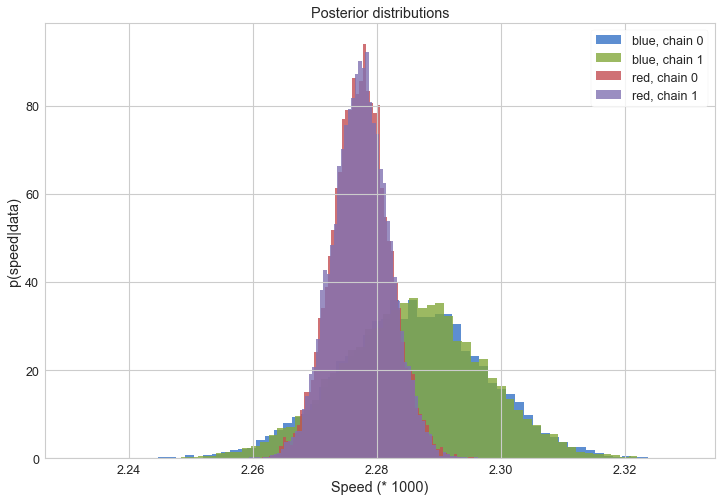

In [4]:
fig, ax = plt.subplots(figsize=(12,8))

which_label={0:'blue', 1:'red'}
for j, trace in enumerate([blue_trace, red_trace]):
    for chain in trace.chains:
        plt.hist(trace.get_values('speed', chains=[chain]), density=True, bins='fd',
                 label=f'{which_label[j]}, chain {chain}', alpha=0.8)
plt.legend()
ax.set_xlabel(f'Speed (* {scl})')
ax.set_ylabel('p(speed|data)')
ax.set_title('Posterior distributions')
plt.show()

# Part (b)

The time where the object crosses true_Y = 0 is calculated as tYZero in the MCMC simulation

In [5]:
from collections import Counter
def get_595Quantile(trace, varname='tYZero'):
    quantiles = pm.quantiles(trace, [5,95])
    
    # average over the chains
    sums = Counter()
    counters = Counter()
    for chain in quantiles:
        sums.update(quantiles[chain][varname])
        counters.update(quantiles[chain][varname].keys())
    quantile595 = {x: float(sums[x])/counters[x] for x in sums.keys()}

    return quantile595

In [6]:
blue595 = get_595Quantile(blue_trace)
print('Blue object\n' + '-'*50)
print(blue595)

print('Red object\n' + '-'*50)
print(get_595Quantile(red_trace))

Blue object
--------------------------------------------------
{5: 572.3337233382048, 95: 577.1040515839427}
Red object
--------------------------------------------------
{5: 433.02995894637394, 95: 434.8671647223973}


Since these are extremely non-overlapping, we can simply take the later of the times:

In [7]:
print('First time when Y_blue>=0 and Y_red <= 0:\n' + '-'*50)
print(f'5% - 95% confidence interval: ({blue595[5]:.2f},  {blue595[95]:.2f})')

First time when Y_blue>=0 and Y_red <= 0:
--------------------------------------------------
5% - 95% confidence interval: (572.33,  577.10)


# Part (c)

If the two objects have the same speed v, this reduces the number of free parameters from 4 ($v_\text{red,x}$,   $v_\text{red,y}$,   $v_\text{blue,x}$,   $v_\text{blue,y}$) to 3. We can parameterize these as the speed $v$, and angles $\theta_\text{red}$ and $\theta_\text{blue}$ such that
* $v_\text{red,x} = v \cos\theta_\text{red}$
* $v_\text{red,y} = v \sin\theta_\text{red}$
* $v_\text{blue,x} = v \cos\theta_\text{blue}$
* $v_\text{blue,y} = v \sin\theta_\text{blue}$

We'll create a model with similarly broad priors that use the results from the last section as starting points, and fits both objects at the same time

In [8]:
v00 = np.mean([red_trace['speed'], blue_trace['speed']])
theta_red_00 =  np.arcsin( np.mean([red_trace['vY']])  /  np.mean([red_trace['speed']]  ))
theta_blue_00 = np.arcsin( np.mean([blue_trace['vY']]) /  np.mean([blue_trace['speed']] ))

def mcmc_fixed_speed(df=df):
    
    T = df['t']
    Xred  = df['red_pos_X']
    Yred  = df['red_pos_Y']
    Xblue = df['blue_pos_X']
    Yblue = df['blue_pos_Y']

    linefitXred = np.polyfit(T, Xred, 1)
    sigma_Xred = np.std(Xred - (linefitXred[0]*T + linefitXred[1]))
    linefitYred = np.polyfit(T, Yred, 1)
    sigma_Yred = np.std(Yred - (linefitYred[0]*T + linefitYred[1]))
    linefitXblue = np.polyfit(T, Xblue, 1)
    sigma_Xblue = np.std(Xblue - (linefitXblue[0]*T + linefitXblue[1]))
    linefitYblue = np.polyfit(T, Yblue, 1)
    sigma_Yblue = np.std(Yblue - (linefitYblue[0]*T + linefitYblue[1]))    
    
    with pm.Model() as model:
        # priors for unknown model parameters
        x0red = pm.Normal('x0red',   mu=linefitXred[1],  sd=10*sigma_Xred)
        y0red = pm.Normal('y0red',   mu=linefitYred[1],  sd=10*sigma_Yred)
        x0blue = pm.Normal('x0blue', mu=linefitXblue[1], sd=10*sigma_Xblue)
        y0blue = pm.Normal('y0blue', mu=linefitYblue[1], sd=10*sigma_Yblue)

        sigmaXred = pm.HalfNormal('sigmaXred', sd=10*sigma_Xred)
        sigmaYred = pm.HalfNormal('sigmaYred', sd=10*sigma_Yred)
        sigmaXblue = pm.HalfNormal('sigmaXblue', sd=10*sigma_Xblue)
        sigmaYblue = pm.HalfNormal('sigmaYblue', sd=10*sigma_Yblue)

        
        speed = pm.Normal('speed', mu=v00, sd=v00)
        theta_red = pm.Normal('theta_red', mu=theta_red_00, sd=1)
        theta_blue = pm.Normal('theta_blue', mu=theta_blue_00, sd=1)
        
        # Deterministic calculated quantities of interest from model parameters
        vXred =  pm.Deterministic('vXred',  speed*np.cos(theta_red) )
        vYred =  pm.Deterministic('vYred',  speed*np.sin(theta_red) )
        vXblue = pm.Deterministic('vXblue', speed*np.cos(theta_blue))
        vYblue = pm.Deterministic('vYblue', speed*np.sin(theta_blue))
        
        tYZeroRed  = pm.Deterministic('tYZeroRed',  -y0red/(vYred/scl))
        tYZeroBlue = pm.Deterministic('tYZeroBlue', -y0blue/(vYblue/scl))
        
        # expected value of outcome
        muXred  = x0red  + vXred/scl  * T
        muYred  = y0red  + vYred/scl  * T
        muXblue = x0blue + vXblue/scl * T
        muYblue = y0blue + vYblue/scl * T
        
        # likelihood (sampling distribution) of observations
        X_red_obs = pm.Normal('X_red_obs', mu=muXred, sd=sigmaXred, observed=Xred)
        Y_red_obs = pm.Normal('Y_red_obs', mu=muYred, sd=sigmaYred, observed=Yred)
        X_blue_obs = pm.Normal('X_blue_obs', mu=muXblue, sd=sigmaXblue, observed=Xblue)
        Y_blue_obs = pm.Normal('Y_blue_obs', mu=muYblue, sd=sigmaYblue, observed=Yblue)
        
    with model:
        step = pm.NUTS()
        trace = pm.sample(50000, step=step, njobs=1, tune=1000)
        
    burned_in = trace[1000:]
    thinned = burned_in[::5] 

    return thinned

In [9]:
same_speed_trace = mcmc_fixed_speed()

/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [theta_blue, theta_red, speed, sigmaYblue_log__, sigmaXblue_log__, sigmaYred_log__, sigmaXred_log__, y0blue, x0blue, y0red, x0red]
100%|██████████| 51000/51000 [05:46<00:00, 147.35it/s]


## Same-speed comparison with (a)

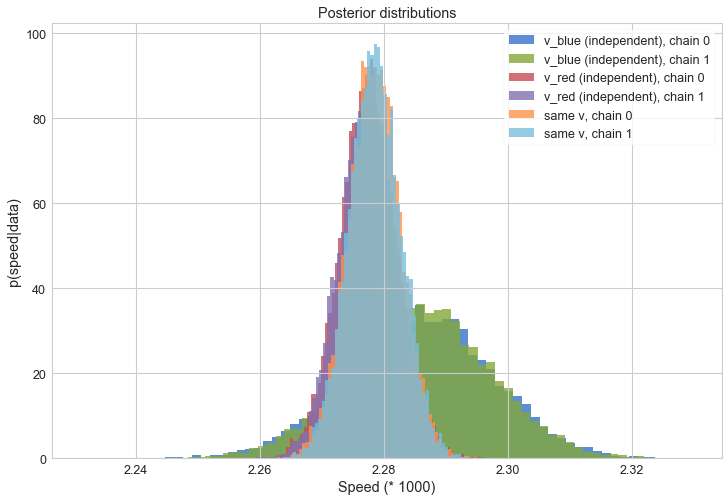

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
which_label={0:'v_blue (independent)', 1:'v_red (independent)', 2:'same v', }
for j, trace in enumerate([blue_trace, red_trace, same_speed_trace]):
    for chain in trace.chains:
        plt.hist(trace.get_values('speed', chains=[chain]), density=True, bins='fd',
                 label=f'{which_label[j]}, chain {chain}', alpha=0.8)
plt.legend()
ax.set_xlabel(f'Speed (* {scl})')
ax.set_ylabel('p(speed|data)')
ax.set_title('Posterior distributions')
plt.show()

So enforcing the same v takes on mostly the form of the (narrower) red speed, shifted a bit towards the blue speed.

## Same-speed comparison with (b)

In [11]:
blue595samev = get_595Quantile(same_speed_trace, varname='tYZeroBlue')
print('First time when Y_blue>=0 and Y_red <= 0:\n' + '-'*50)
print(f'5% - 95% confidence interval: ({blue595samev[5]:.2f},  {blue595samev[95]:.2f})')
print('\nCompared with:\n' + '-'*50)
print(f'5% - 95% confidence interval: ({blue595[5]:.2f},  {blue595[95]:.2f})')

First time when Y_blue>=0 and Y_red <= 0:
--------------------------------------------------
5% - 95% confidence interval: (572.69,  577.25)

Compared with:
--------------------------------------------------
5% - 95% confidence interval: (572.33,  577.10)


Very tiny shift; seems pretty unaffected.

# Part (d)

## comparison with (a)

In [12]:
blue_trace100 = mcmc_measurement('blue', df=df[:100])
red_trace100 = mcmc_measurement('red', df=df[:100])

/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [sigmaY_log__, vY, y0, sigmaX_log__, vX, x0]
100%|██████████| 51000/51000 [02:47<00:00, 304.20it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [sigmaY_log__, vY, y0, sigmaX_log__, vX, x0]
100%|██████████| 51000/51000 [02:40<00:00, 317.16it/s]


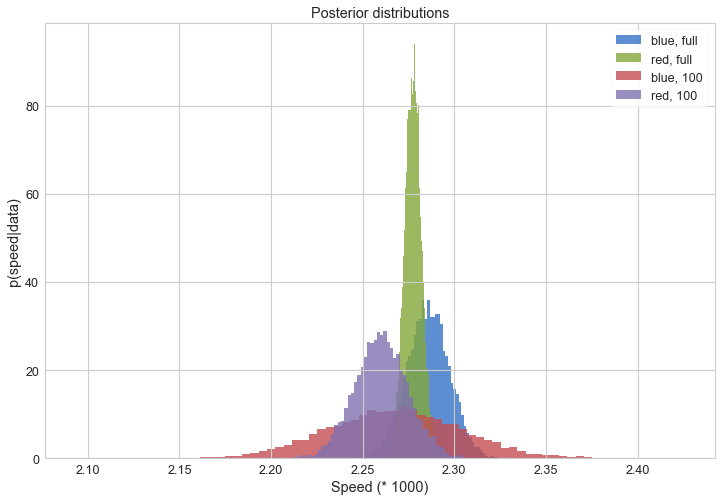

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

# only look at one chain for each
which_label={0:'blue, full', 1:'red, full', 2:'blue, 100', 3:'red, 100', }
for j, trace in enumerate([blue_trace, red_trace, blue_trace100, red_trace100]):
        plt.hist(trace.get_values('speed', chains=[0]), density=True, bins='fd',
                 label=f'{which_label[j]}', alpha=0.8)
plt.legend()
ax.set_xlabel(f'Speed (* {scl})')
ax.set_ylabel('p(speed|data)')
ax.set_title('Posterior distributions')
plt.show()

Including more data significantly narrows up both distributions, and shifts the mean of the speed distribution up.

## comparison with (b)

In [14]:
blue595_100 = get_595Quantile(blue_trace100)

print('First time when Y_blue>=0 and Y_red <= 0 with only 100 points:\n' + '-'*50)
print(f'5% - 95% confidence interval: ({blue595_100[5]:.2f},  {blue595_100[95]:.2f})')
print('\nCompared with:\n' + '-'*50)
print(f'5% - 95% confidence interval: ({blue595[5]:.2f},  {blue595[95]:.2f})')

First time when Y_blue>=0 and Y_red <= 0 with only 100 points:
--------------------------------------------------
5% - 95% confidence interval: (568.07,  588.60)

Compared with:
--------------------------------------------------
5% - 95% confidence interval: (572.33,  577.10)


Wider confidence interval with fewer points, as you'd expect.

## comparison with (c)

In [15]:
same_speed_trace100 = mcmc_fixed_speed(df[:100])

/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [theta_blue, theta_red, speed, sigmaYblue_log__, sigmaXblue_log__, sigmaYred_log__, sigmaXred_log__, y0blue, x0blue, y0red, x0red]
100%|██████████| 51000/51000 [05:12<00:00, 163.45it/s]


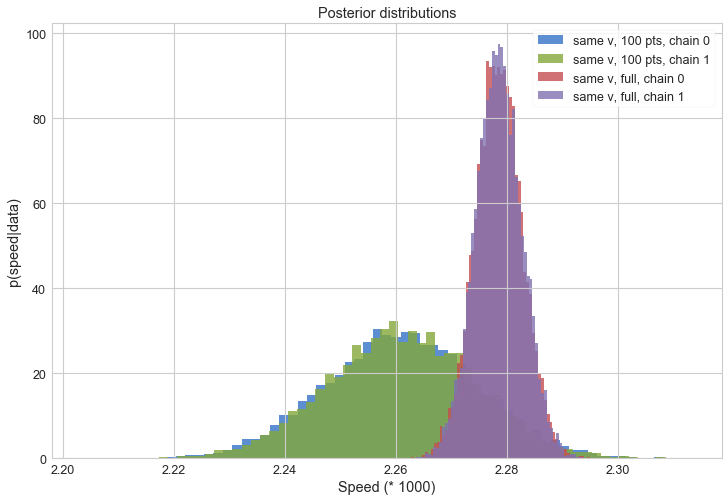

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
which_label={0:'same v, 100 pts', 1:'same v, full', }
for j, trace in enumerate([same_speed_trace100, same_speed_trace]):
    for chain in trace.chains:
        plt.hist(trace.get_values('speed', chains=[chain]), density=True, bins='fd',
                 label=f'{which_label[j]}, chain {chain}', alpha=0.8)
plt.legend()
ax.set_xlabel(f'Speed (* {scl})')
ax.set_ylabel('p(speed|data)')
ax.set_title('Posterior distributions')
plt.show()

Same as in the comparison with (a): including more data significantly narrows up both distributions, and shifts the mean of the speed distribution up.